# CyRK - SciPy Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import njit
plt.style.use('dark_background')

### Create a differential equation to test

In [2]:
from CyRK.cy.cysolvertest import CySolverTester

initial_conds = np.asarray((20., 20.), dtype=np.float64)
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

@njit
def diffeq(t, y, dy):
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]


# Create helper function for scipy to work with this kind of diffeq
@njit
def diffeq_scipy(t, y):
    
    dy = np.zeros_like(y)
    diffeq(t, y, dy)
    
    return dy


# Create plotting routine
def diff_plot(t, y, fig_name=None):
    
    # Plot
    fig, ax = plt.subplots()
    ax.plot(t, y[0], 'r', label='$y_{0}$')
    ax.plot(t, y[1], 'b', label='$y_{1}$')
    ax.set(xlabel='$t$', ylabel='$y$')
    ax.legend(loc='best')
    
    # Show figure
    plt.show()
    
    # Save figure
    if fig_name is not None:
        fig.savefig(f'{fig_name}.pdf')

### Check results

SciPy Solution


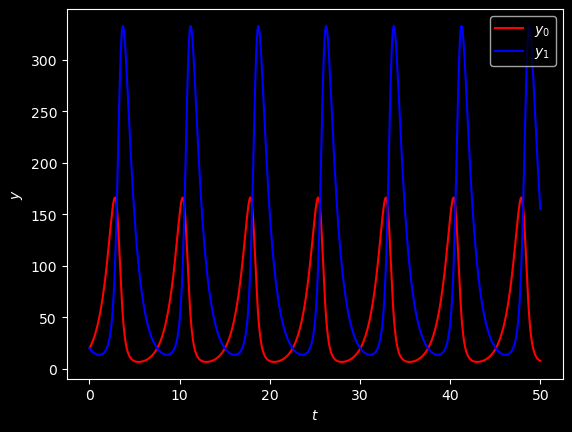

In [3]:
# Scipy
scipy_solution = solve_ivp(diffeq_scipy, time_span, initial_conds, method='RK45', rtol=rtol, atol=atol)
print('SciPy Solution')
diff_plot(scipy_solution.t, scipy_solution.y, fig_name='SciPy')

CyRK (numba) Solution


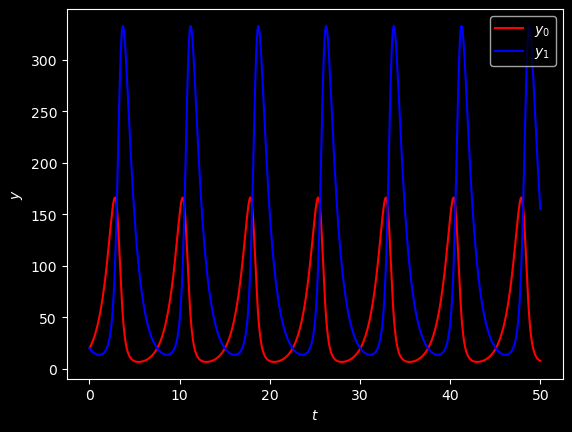

In [4]:
# CyRK - numba implementation
from CyRK import nbrk_ode
time_domain_nb, y_results_nb, success_nb, message_nb = \
    nbrk_ode(diffeq_scipy, time_span, initial_conds, rk_method=1, rtol=rtol, atol=atol)
print('CyRK (numba) Solution')
diff_plot(time_domain_nb, y_results_nb, fig_name='CyRK_numba')

CyRK (Cython - cyrk_ode) Solution


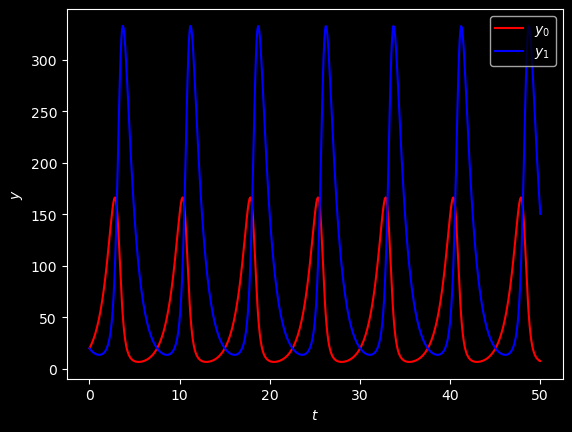

In [5]:
# CyRK -  Cython cyrk_ode
from CyRK import cyrk_ode
time_domain, y_results, success, message = cyrk_ode(diffeq, time_span, initial_conds,
                                                    rk_method=1, rtol=rtol, atol=atol)
print('CyRK (Cython - cyrk_ode) Solution')
diff_plot(time_domain, y_results, fig_name='CyRK_cyrk_ode')

CyRK (Cython - CySolver) Solution


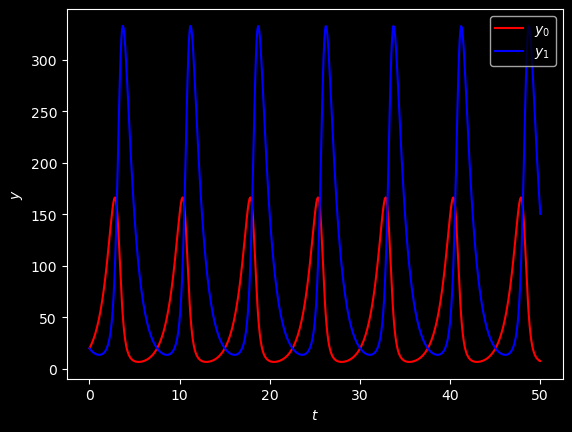

In [6]:
# CyRK - Cython CySolver
CySolverTesterInst = CySolverTester(time_span, initial_conds, rk_method=1, rtol=rtol, atol=atol, auto_solve=True)
print('CyRK (Cython - CySolver) Solution')
diff_plot(time_domain, y_results, fig_name='CyRK_CySolver')

### Check Performance

In [7]:
import timeit

REPEATS = 4
print('This can take a while...\n')
# Run Results
# rtols = np.logspace(-3, -13, 11)
end_times = np.logspace(-3, 5, 9)

sci_times = list()
nb_times = list()
cy_times = list()
cysolver_times = list()

sci_errors = list()
nb_errors = list()
cy_errors = list()
cysolver_errors = list()

for end_time in end_times:
    
    time_s = (0., end_time)
    
    print(f'Working on end_time = {end_time:0.1e}.')
    print(f'\tNumba Pre-Compile')
    _ = nbrk_ode(diffeq_scipy, time_s, initial_conds, rk_method=1, rtol=rtol, atol=atol)
    
    print('\tWorking on SciPy')
    sci_timer = timeit.Timer(lambda: solve_ivp(diffeq_scipy, time_s, initial_conds, method='RK45', rtol=rtol, atol=atol))
    scipy_time_list = list()
    for i in range(REPEATS):
        N, T = sci_timer.autorange()
        scipy_time_list.append(T / N * 1000.)
    scipy_time_list = np.asarray(scipy_time_list)
    sci_times.append(np.average(scipy_time_list))
    sci_errors.append(np.std(scipy_time_list))
    print('\tFinished SciPy.')
    
    print('\tWorking on numba')
    nb_timer = timeit.Timer(lambda: nbrk_ode(diffeq_scipy, time_s, initial_conds, rk_method=1, rtol=rtol, atol=atol))
    nb_times_list = list()
    for i in range(REPEATS):
        N, T = nb_timer.autorange()
        nb_times_list.append(T / N * 1000.)
    nb_times_list = np.asarray(nb_times_list)
    nb_times.append(np.average(nb_times_list))
    nb_errors.append(np.std(nb_times_list))
    print('\tFinished numba.')
    
    print('\tWorking on cython - cyrk_ode')
    cy_timer = timeit.Timer(lambda: cyrk_ode(diffeq, time_s, initial_conds, rk_method=1, rtol=rtol, atol=atol))
    cy_times_list = list()
    for i in range(REPEATS):
        N, T = cy_timer.autorange()
        cy_times_list.append(T / N * 1000.)
    cy_times_list = np.asarray(cy_times_list)
    cy_times.append(np.average(cy_times_list))
    cy_errors.append(np.std(cy_times_list))
    print('\tFinished cython - cyrk_ode.')
    
    print('\tWorking on cython - CySolver')
    cysolver_timer = timeit.Timer(lambda: CySolverTester(time_s, initial_conds, rk_method=1, rtol=rtol, atol=atol, auto_solve=True))
    cysolver_times_list = list()
    for i in range(REPEATS):
        N, T = cysolver_timer.autorange()
        cysolver_times_list.append(T / N * 1000.)
    cysolver_times_list = np.asarray(cysolver_times_list)
    cysolver_times.append(np.average(cysolver_times_list))
    cysolver_errors.append(np.std(cysolver_times_list))
    print('\tFinished cython - CySolver.')
    
print('Done!')

This can take a while...

Working on end_time = 1.0e-03.
	Numba Pre-Compile
	Working on SciPy
	Finished SciPy.
	Working on numba
	Finished numba.
	Working on cython - cyrk_ode
	Finished cython - cyrk_ode.
	Working on cython - CySolver
	Finished cython - CySolver.
Working on end_time = 1.0e-02.
	Numba Pre-Compile
	Working on SciPy
	Finished SciPy.
	Working on numba
	Finished numba.
	Working on cython - cyrk_ode
	Finished cython - cyrk_ode.
	Working on cython - CySolver
	Finished cython - CySolver.
Working on end_time = 1.0e-01.
	Numba Pre-Compile
	Working on SciPy
	Finished SciPy.
	Working on numba
	Finished numba.
	Working on cython - cyrk_ode
	Finished cython - cyrk_ode.
	Working on cython - CySolver
	Finished cython - CySolver.
Working on end_time = 1.0e+00.
	Numba Pre-Compile
	Working on SciPy
	Finished SciPy.
	Working on numba
	Finished numba.
	Working on cython - cyrk_ode
	Finished cython - cyrk_ode.
	Working on cython - CySolver
	Finished cython - CySolver.
Working on end_time = 

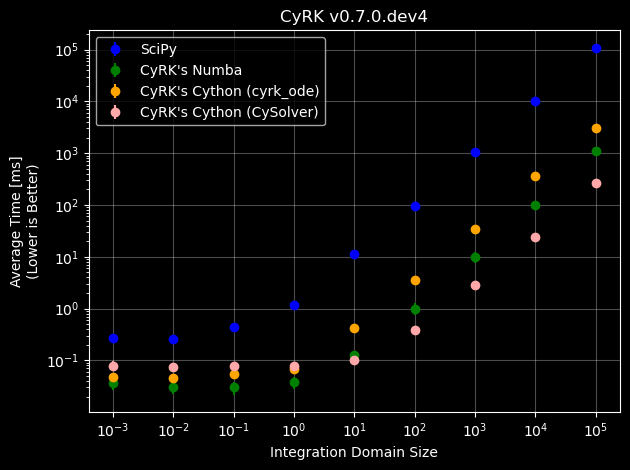

In [8]:
from CyRK import version

version_filesafe = version.replace('.', '-')

# Plot Results
sci_times = np.asarray(sci_times)
nb_times = np.asarray(nb_times)
cy_times = np.asarray(cy_times)
cysolver_times = np.asarray(cysolver_times)

sci_errors = np.asarray(sci_errors)
nb_errors = np.asarray(nb_errors)
cy_errors = np.asarray(cy_errors)
cysolver_errors = np.asarray(cysolver_errors)

fig, ax = plt.subplots()

ax.errorbar(end_times, sci_times, yerr=sci_errors, c='blue', label='SciPy', fmt='o')
ax.errorbar(end_times, nb_times, yerr=nb_errors, c='green', label="CyRK's Numba", fmt='o')
ax.errorbar(end_times, cy_times, yerr=cy_errors, c='orange', label="CyRK's Cython (cyrk_ode)", fmt='o')
ax.errorbar(end_times, cysolver_times, yerr=cysolver_errors, c='#ffa8a9', label="CyRK's Cython (CySolver)", fmt='o')

ax.set(ylabel='Average Time [ms]\n(Lower is Better)', xlabel='Integration Domain Size', xscale='log', yscale='log',
       title=f'CyRK v{version} vs. SciPy')
ax.set_xticks((1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5))
ax.grid(alpha=0.3)
# ax.set_xlim(ax.get_xlim()[::-1])

ax.legend(loc='best')
ax.set(title=f'CyRK v{version}')
fig.tight_layout()
fig.savefig(f'CyRK_SciPy_Compare_v{version_filesafe}.png')
plt.show()

In [9]:
# Print Differences
for end_time, sci, nb, cy, cys in zip(end_times, sci_times, nb_times, cy_times, cysolver_times):
    
    nb_perc_diff = sci / nb
    cy_perc_diff = sci / cy
    cys_perc_diff = sci / cys
    nbcy_perc_diff = cy / nb
    cyscy_perc_diff = cys / nb
    print(f'end_time-{end_time:0.1e}: Numba={nb_perc_diff:0.3f}x; Cython(cryk_ode)={cy_perc_diff:0.3f}x; Cython(CySolver)={cys_perc_diff:0.3f}x; NbCy={nbcy_perc_diff:0.3f}x; NbCyS={cyscy_perc_diff:0.3f}x')

end_time-1.0e-03: Numba=7.243x; Cython(cryk_ode)=5.702x; Cython(CySolver)=3.392x; NbCy=1.270x; NbCyS=2.135x
end_time-1.0e-02: Numba=8.358x; Cython(cryk_ode)=5.794x; Cython(CySolver)=3.477x; NbCy=1.442x; NbCyS=2.403x
end_time-1.0e-01: Numba=14.333x; Cython(cryk_ode)=7.790x; Cython(CySolver)=5.606x; NbCy=1.840x; NbCyS=2.557x
end_time-1.0e+00: Numba=31.499x; Cython(cryk_ode)=17.577x; Cython(CySolver)=15.219x; NbCy=1.792x; NbCyS=2.070x
end_time-1.0e+01: Numba=87.411x; Cython(cryk_ode)=26.348x; Cython(CySolver)=109.390x; NbCy=3.318x; NbCyS=0.799x
end_time-1.0e+02: Numba=94.580x; Cython(cryk_ode)=26.605x; Cython(CySolver)=243.903x; NbCy=3.555x; NbCyS=0.388x
end_time-1.0e+03: Numba=106.131x; Cython(cryk_ode)=30.681x; Cython(CySolver)=373.961x; NbCy=3.459x; NbCyS=0.284x
end_time-1.0e+04: Numba=103.674x; Cython(cryk_ode)=28.543x; Cython(CySolver)=424.916x; NbCy=3.632x; NbCyS=0.244x
end_time-1.0e+05: Numba=99.546x; Cython(cryk_ode)=34.986x; Cython(CySolver)=411.983x; NbCy=2.845x; NbCyS=0.242x
